# Rete con i 5 filtri in input, dopo ricerca nello spazio degli iperparametri con Hyperopts

Risultato della ricerca:  
Best hyperparameters: {'activation': 0, 'batch_size': 256.0, 'dropout': 0.24565886965791095, 'epochs': 90.0, 'learning_rate': 0.0003033636928156707, 'num_layers': 2.0, 'optimizer': 1, 'units_layer': 224.0}

In [2]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam, RMSprop, SGD
from tensorflow.keras.callbacks import Callback
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelBinarizer

# Iperparametri migliori trovati da Hyperopt
best_hyperparams = {
    'activation': 0, 
    'batch_size': 256,
    'dropout': 0.24565886965791095,
    'epochs': 90,
    'learning_rate': 0.0003033636928156707,
    'num_layers': 2,
    'optimizer': 1,  
    'units_layer': 224
}

# Decodifica degli iperparametri che mappano su interi
activation_functions = ['relu', 'tanh', 'sigmoid']      # 0 = relu, 1 = tanh, 2 = sigmoid
optimizers = [Adam, RMSprop, SGD]                       # 0 = Adam, 1 = RMSprop, 2 = SGD

# Callback personalizzata per stampare solo alcune epoche
class StampaEpochePersonalizzata(Callback):
    def on_epoch_end(self, epoch, logs=None):
        if (epoch + 1) % 3 == 0:  # Stampa solo per epoche multiple di 5
            print(f'Epoca {epoch + 1}: Accuracy={logs["accuracy"]}, Loss={logs["loss"]} ----- Validation Accuracy={logs["val_accuracy"]}, Validation Loss={logs["val_loss"]}')

# Rete Neurale seguendo gli iperparametri
def build_best_model(input_shape):
    model = Sequential()

    # Primo strato
    model.add(Dense(int(best_hyperparams['units_layer']),
                    activation=activation_functions[best_hyperparams['activation']],
                    input_shape=input_shape))
    model.add(Dropout(best_hyperparams['dropout']))

    # Secondo strato (dato che num_layers = 2)
    model.add(Dense(int(best_hyperparams['units_layer']),
                    activation=activation_functions[best_hyperparams['activation']]))
    model.add(Dropout(best_hyperparams['dropout']))

    # Strato di output
    model.add(Dense(3, activation='softmax'))  

    # Compilazione del modello con l'ottimizzatore e il learning rate migliori trovati
    optimizer = optimizers[best_hyperparams['optimizer']](learning_rate=best_hyperparams['learning_rate'])
    model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

    print('--------------------------------------------------------------------------------------------------------------------------------')
    print("Riepilogo della struttura del modello:")
    model.summary()
    print('--------------------------------------------------------------------------------------------------------------------------------')

    return model

# Caricamento e preparazione dei dati
df = pd.read_csv('dataset_rielaborato_filtrato.csv')

# Selezioniamo solo le colonne di interesse (magnitudini e label)
X = df[['u', 'g', 'r', 'i', 'z']].values
Y = np.where(df['label_STAR'], 0, np.where(df['label_GALAXY'], 1, 2))

# Normalizzazione delle magnitudini
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Codifica delle etichette
Y_categorical = to_categorical(Y, num_classes=3)

# Divisione del dataset in train e test
X_train, X_test, Y_train, Y_test = train_test_split(X_scaled, Y_categorical, test_size=0.2, random_state=42)

input_shape = (X_train.shape[1],)                                              # Definisco la forma dell'input

# Costruisco il modello migliore
model = build_best_model(input_shape)

# Addestramento del modello con i migliori iperparametri
history = model.fit(X_train, Y_train,
                    batch_size=int(best_hyperparams['batch_size']),
                    epochs=int(best_hyperparams['epochs']),
                    validation_split = 0.2,
                    verbose = 0,
                    callbacks=[StampaEpochePersonalizzata()])  

# Valutazione finale
test_loss, test_accuracy = model.evaluate(X_test, Y_test)
print('--------------------------------------------------------------------------------------------------------------------------------')
print('Valutazione del modello sui dati di test:')
print(f'Loss su test: {test_loss}')
print(f'Accuratezza su test: {test_accuracy}')
print('--------------------------------------------------------------------------------------------------------------------------------')


--------------------------------------------------------------------------------------------------------------------------------
Riepilogo della struttura del modello:


C:\Users\alban\anaconda3\envs\tff\lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 224)            │         1,344 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 224)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 224)            │        50,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 224)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 3)              │           675 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 52,419 (204.76 KB)

 Trainable params: 52,419 (204.76 KB)

 Non-trainable params: 0 (0.00 B)

--------------------------------------------------------------------------------------------------------------------------------
Epoca 3: Accuracy=0.8022156357765198, Loss=0.5275946855545044 ----- Validation Accuracy=0.8136249780654907, Validation Loss=0.5000767707824707
Epoca 6: Accuracy=0.8364661931991577, Loss=0.45963403582572937 ----- Validation Accuracy=0.8448749780654907, Validation Loss=0.44442009925842285
Epoca 9: Accuracy=0.8504820466041565, Loss=0.4281902611255646 ----- Validation Accuracy=0.8492500185966492, Validation Loss=0.4189584255218506
Epoca 12: Accuracy=0.855919599533081, Loss=0.4082379937171936 ----- Validation Accuracy=0.8566250205039978, Validation Loss=0.3988233208656311
Epoca 15: Accuracy=0.8595290780067444, Loss=0.3952248692512512 ----- Validation Accuracy=0.8599374890327454, Validation Loss=0.3867645263671875
Epoca 18: Accuracy=0.8615915775299072, Loss=0.38714298605918884 ----- Validation Accuracy=0.8603749871253967, Validation Loss=0.379611998796463
Epoca 21:

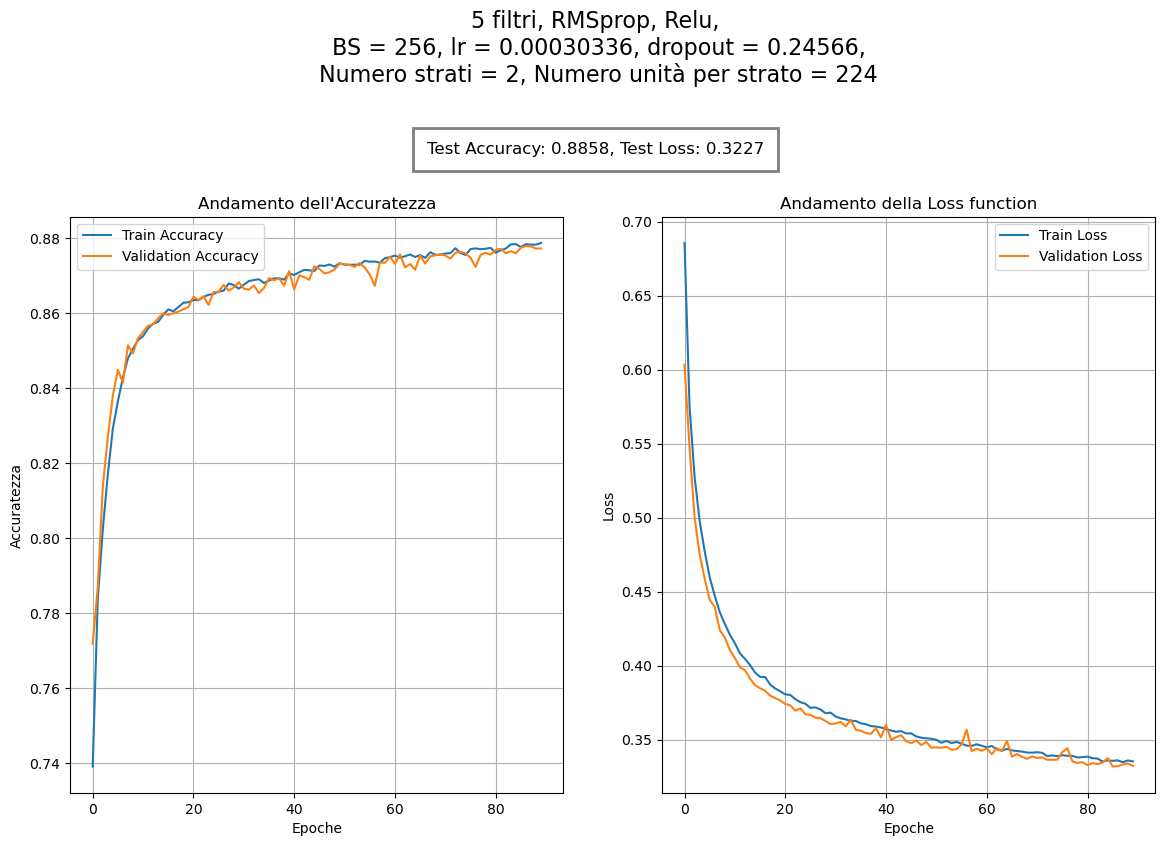

In [3]:
import matplotlib.pyplot as plt
# Grafico dell'andamento dell'accuratezza e della loss durante l'addestramento
plt.figure(figsize=(14, 9))

AAA = best_hyperparams['batch_size']
BBB = best_hyperparams['learning_rate']
CCC = best_hyperparams['num_layers']
DDD = best_hyperparams['units_layer']
EEE = best_hyperparams['dropout']


# Aggiungi un titolo grande sopra tutti i sottoplot
plt.suptitle(f'5 filtri, RMSprop, Relu,\n BS = {AAA}, lr = {BBB:.8f}, dropout = {EEE:.5f},\n Numero strati = {CCC}, Numero unità per strato = {DDD}', fontsize=16)

plt.figtext(0.5, 0.82, f'Test Accuracy: {test_accuracy:.4f}, Test Loss: {test_loss:.4f}', 
            ha='center', fontsize=12, 
            bbox={'facecolor': 'white', 'alpha': 0.5, 'pad': 10, 'edgecolor': 'black', 'linewidth': 2})

# Grafico dell'accuratezza
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Andamento dell\'Accuratezza')
plt.xlabel('Epoche')
plt.ylabel('Accuratezza')
plt.legend()
plt.grid(True) 

# Grafico della loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Andamento della Loss function')
plt.xlabel('Epoche')
plt.ylabel('Loss')
plt.legend()
plt.grid(True) 

# Aggiungi spazio tra il riquadro e i grafici
plt.subplots_adjust(top=0.75)  # Aumenta lo spazio sopra i grafici

# Salvo l'immagine
plt.savefig('./Immagini/Hyperopt_5 filtri_vecchio_normalizzato3.png')

plt.show()

625/625 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step


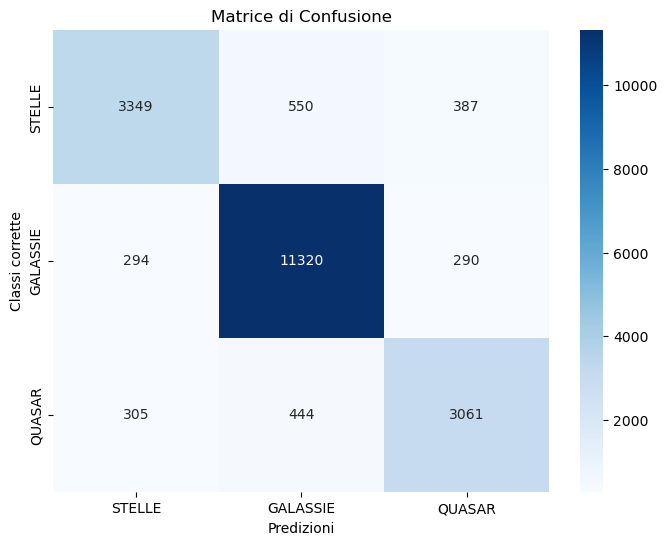

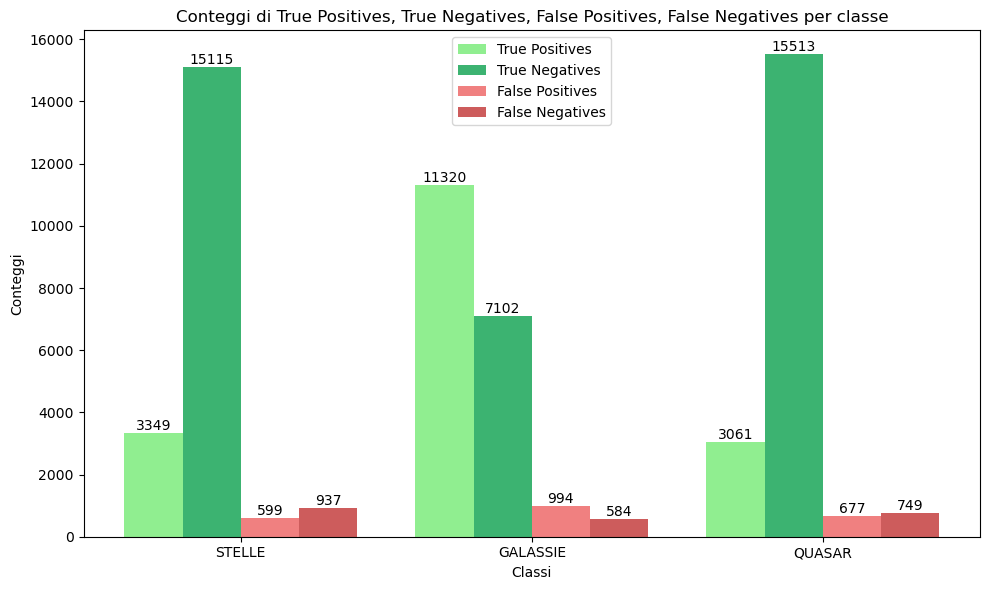

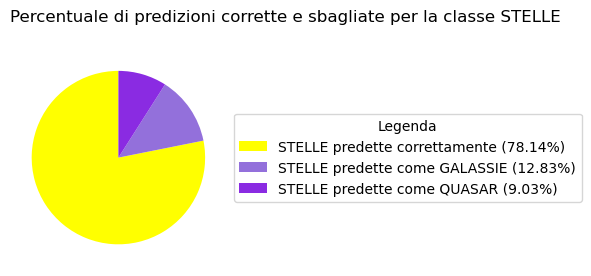

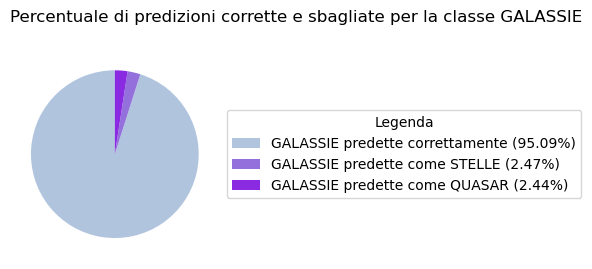

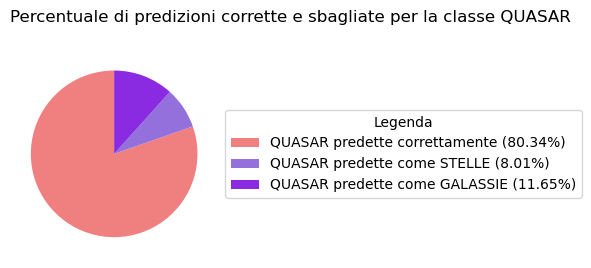

In [15]:
import seaborn as sns
import matplotlib.pyplot as plt  # Import necessario per i plot
from sklearn.metrics import confusion_matrix
import numpy as np

colori = {
    'STELLE': 'yellow',
    'GALASSIE': 'lightsteelblue',
    'QUASAR': 'lightcoral'
}
# Classi
classi = ['STELLE', 'GALASSIE', 'QUASAR']

# PREDIZIONE E MATRICE DI CONFUSIONE ------------------------------------------------------------------------------------------------------------------------
# Predizioni sui dati di test
Y_test_pred = model.predict(X_test)
Y_test_pred_classes = np.argmax(Y_test_pred, axis=1)  # Ottieni le classi predette
Y_test_true_classes = np.argmax(Y_test, axis=1)  # Ottieni le classi vere (da one-hot a classi)

# Confusion Matrix
conf_matrix = confusion_matrix(Y_test_true_classes, Y_test_pred_classes)

# Creazione della matrice di confusione
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', 
            xticklabels=classi, yticklabels=classi)

plt.title('Matrice di Confusione')
plt.xlabel('Predizioni')
plt.ylabel('Classi corrette')
plt.savefig('./Immagini/Confusion_matrix_batch256.png')
plt.show()

# GRAFICO A BARRE-------------------------------------------------------------------------------------------------------------------------------
# Calcolo di TP, TN, FP, FN per ciascuna classe
TP = np.diag(conf_matrix)  # True Positives sono sulla diagonale
FP = conf_matrix.sum(axis=0) - TP  # False Positives: somma su colonna meno i TP
FN = conf_matrix.sum(axis=1) - TP  # False Negatives: somma su riga meno i TP
TN = conf_matrix.sum() - (FP + FN + TP)  # True Negatives: tutto il resto

# Grafico a barre per TP, TN, FP, FN
labels = ['True Positives', 'True Negatives', 'False Positives', 'False Negatives']
bar_width = 0.2
index = np.arange(len(classi))

plt.figure(figsize=(10, 6))

# Plottiamo i valori per ciascuna classe con colori personalizzati
bars1 = plt.bar(index, TP, bar_width, label='True Positives', color='lightgreen')  # Verde chiaro
bars2 = plt.bar(index + bar_width, TN, bar_width, label='True Negatives', color='mediumseagreen')  # Verde medio
bars3 = plt.bar(index + 2 * bar_width, FP, bar_width, label='False Positives', color='lightcoral')  # Rosso chiaro
bars4 = plt.bar(index + 3 * bar_width, FN, bar_width, label='False Negatives', color='indianred')  # Rosso medio

# Aggiungiamo i numeri sopra ogni barra
for bars in [bars1, bars2, bars3, bars4]:
    for bar in bars:
        yval = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2, yval + 0.5, int(yval), ha='center', va='bottom')

# Aggiustiamo le etichette e il layout
plt.xlabel('Classi')
plt.ylabel('Conteggi')
plt.title('Conteggi di True Positives, True Negatives, False Positives, False Negatives per classe')
plt.xticks(index + 1.5 * bar_width, classi)
plt.legend()

plt.tight_layout()
plt.savefig('./Immagini/TPTNFPFN_batch256.png')
plt.show()

# GRAFICI A TORTA-----------------------------------------------------------------------------------------------------------------------
for i, classe in enumerate(classi):
    true_class_total = conf_matrix[i].sum()  # Totale di questa classe reale (righe)
    correct_predictions = TP[i]  # True Positives per questa classe
    wrong_as_other_classes = [conf_matrix[i, j] for j in range(len(classi)) if i != j]  # Predetti come altre classi
    
    # Percentuali per il grafico a torta
    percentages = [correct_predictions / true_class_total * 100] + [wrong / true_class_total * 100 for wrong in wrong_as_other_classes]

    # Etichette con le percentuali per la legenda
    labels = [f'{classe} predette correttamente ({percentages[0]:.2f}%)']
    p = 1
    for j in range(len(classi)):
        if i != j:  # Controlla se la classe non è quella corretta
            labels.append(f'{classe} predette come {classi[j]} ({percentages[p]:.2f}%)')
            p += 1

    # Creazione del grafico a torta
    plt.figure(figsize=(6, 6))
    wedges, texts = plt.pie(percentages, startangle=90, colors=[colori[classi[i]], 'mediumpurple', 'blueviolet'])
    
    # Aggiunta della legenda di fianco al grafico con percentuali
    plt.legend(wedges, labels, title="Legenda", loc="center left", bbox_to_anchor=(1, 0, 0.5, 1))
    
    # Titolo del grafico
    plt.title(f'Percentuale di predizioni corrette e sbagliate per la classe {classe}', loc='left', pad=20)
    plt.tight_layout()
    plt.savefig(f'./Immagini/Torta_{classe}_batch256.png')
    plt.show()

625/625 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step


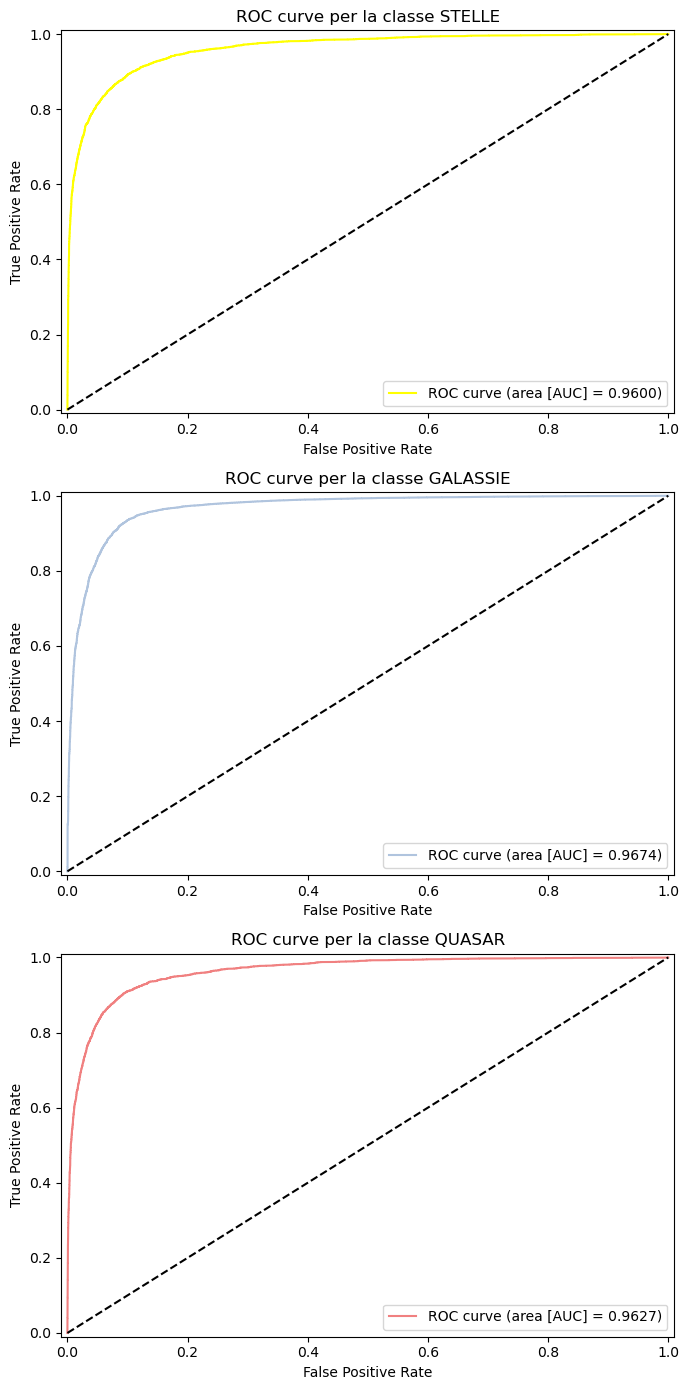

In [7]:
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_curve, auc

colori = {
    'STELLE': 'yellow',
    'GALASSIE': 'lightsteelblue',
    'QUASAR': 'lightcoral'
}
# Classi
classi = ['STELLE', 'GALASSIE', 'QUASAR']

# Binarizzazione dei target (porto in formato binario per facilitare ROC curve)
Y_train_bin = Y_train
Y_test_bin = Y_test

# Calcolo delle predizioni
Y_test_pred = model.predict(X_test)

# Calcolo delle ROC curve e AUC per ciascuna classe
n_classes = 3
y_test_bin = label_binarize(Y_test.argmax(axis=1), classes=[0, 1, 2])  # Binarizza le etichette
fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], Y_test_pred[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Grafico delle ROC curve
plt.figure(figsize=(7, 14))

for i in range(n_classes):
    plt.subplot(3, 1, i + 1)
    plt.plot(fpr[i], tpr[i], label='ROC curve (area [AUC] = {:.4f})'.format(roc_auc[i]), color=colori[classi[i]]) 
    plt.plot([0, 1], [0, 1], 'k--')  # Linea diagonale
    plt.xlim([-0.01, 1.01])
    plt.ylim([-0.01, 1.01])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'ROC curve per la classe {classi[i]}')
    plt.legend(loc='lower right')

plt.tight_layout()
plt.savefig(f'./Immagini/ROC_batch256.png')
plt.show()